# 1. Importing Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import json
import ast
import warnings
warnings.filterwarnings('ignore')

# Data preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Feature engineering
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

# Models
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    AdaBoostClassifier,
    VotingClassifier
)
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

# Model evaluation
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Utilities
import joblib
import pickle
from datetime import datetime
import time
import sys
import os

# 2. Data Loading and Initial Exploration

In [3]:
def load_and_explore_data(file_path):
    """
    Load the dataset and perform initial exploration
    """
    print("="*50)
    print("LOADING DATASET")
    print("="*50)
    
    # Load the dataset
    df = pd.read_csv(file_path)
    
    print(f"Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"\nData types:\n{df.dtypes}")
    print(f"\nMissing values:\n{df.isnull().sum()}")
    
    # Display basic statistics
    print(f"\nFirst 5 rows:")
    print(df.head())
    
    return df

# Load dataset
dataset_path = "/kaggle/input/predictive-financial-impact-and-risk-forecasting/cybersecurity_risk_dataset_50000.csv"
df = load_and_explore_data(dataset_path)

LOADING DATASET
Dataset loaded successfully!
Shape: (50000, 22)
Columns: ['scenario_id', 'timestamp', 'scenario_type', 'threat_type', 'attack_vector', 'threat_intelligence_score', 'attack_complexity', 'initial_access_method', 'assets_affected', 'asset_count', 'hardware_risk_avg', 'software_risk_avg', 'network_segment_risk', 'data_classification_risk', 'historical_incidents', 'historical_incident_count', 'avg_days_since_last_similar', 'business_context', 'existing_controls', 'prediction_results', 'mitigation_options', 'optimal_mitigation_set']

Data types:
scenario_id                     object
timestamp                       object
scenario_type                   object
threat_type                     object
attack_vector                   object
threat_intelligence_score      float64
attack_complexity               object
initial_access_method           object
assets_affected                 object
asset_count                     object
hardware_risk_avg              float64
software_

# 3. Data Preprocessing Function

In [5]:
# If df_processed is not defined, you need to create it first
# Assuming you have your original dataframe 'df'

import pandas as pd
import numpy as np

# Load or create your dataframe
# df = pd.read_csv('your_file.csv')  # Uncomment and modify as needed

# If you need to preprocess the data first:
def preprocess_data(df):
    """
    Basic preprocessing function
    """
    df_processed = df.copy()
    
    # Add any preprocessing steps here
    # For example, convert JSON-like columns if needed
    import ast
    
    def safe_parse(x):
        try:
            if isinstance(x, str):
                return ast.literal_eval(x)
            return x
        except:
            return {}
    
    # Parse JSON columns if they exist
    json_columns = ['asset_count', 'business_context', 'existing_controls', 'prediction_results']
    for col in json_columns:
        if col in df_processed.columns:
            df_processed[f'{col}_parsed'] = df_processed[col].apply(safe_parse)
    
    return df_processed

# DEFINE THE FEATURE CREATION FUNCTION FIRST
def create_predictive_features(df_processed):
    """
    Create features that are actually predictive of cybersecurity risk
    """
    print("="*50)
    print("CREATING PREDICTIVE FEATURES")
    print("="*50)
    
    # Start with existing numeric columns
    X = df_processed.select_dtypes(include=[np.number]).copy()
    
    # Remove problematic columns
    columns_to_remove = [
        'historical_incident_count',  # Constant feature
        'year', 'month', 'day', 'day_of_week',  # Time features may not be predictive
        'business_employee_count_log'  # Highly correlated with business_employee_count
    ]
    
    existing_remove = [col for col in columns_to_remove if col in X.columns]
    X = X.drop(columns=existing_remove)
    
    print(f"Removed {len(existing_remove)} non-predictive columns")
    
    # Create interaction features from top correlated features
    print("\nCreating interaction features...")
    
    # Based on your correlation analysis
    top_features = [
        'pred_impact_components.recovery_cost',
        'hardware_risk_avg',
        'avg_days_since_last_similar',
        'asset_critical_assets',
        'pred_recommended_investment'
    ]
    
    existing_top = [f for f in top_features if f in X.columns]
    
    for i in range(len(existing_top)):
        for j in range(i+1, len(existing_top)):
            feat1 = existing_top[i]
            feat2 = existing_top[j]
            X[f'{feat1}_x_{feat2}'] = X[feat1] * X[feat2]
            X[f'{feat1}_plus_{feat2}'] = X[feat1] + X[feat2]
    
    # Create risk composite scores
    print("\nCreating composite risk scores...")
    
    # Hardware-Software risk interaction
    if all(col in X.columns for col in ['hardware_risk_avg', 'software_risk_avg']):
        X['total_system_risk'] = X['hardware_risk_avg'] + X['software_risk_avg']
        X['system_risk_ratio'] = X['hardware_risk_avg'] / (X['software_risk_avg'] + 1e-10)
    
    # Network and data risk
    if all(col in X.columns for col in ['network_segment_risk', 'data_classification_risk']):
        X['infrastructure_risk'] = X['network_segment_risk'] + X['data_classification_risk']
    
    # Business risk exposure
    business_risk_cols = [
        'business_industry_risk_factor',
        'business_compliance_penalty_factor',
        'business_data_sensitivity_index'
    ]
    
    existing_business = [col for col in business_risk_cols if col in X.columns]
    if existing_business:
        X['business_risk_composite'] = X[existing_business].mean(axis=1)
    
    # Asset criticality score
    if all(col in X.columns for col in ['asset_hardware', 'asset_software', 'asset_critical_assets']):
        total_assets = X['asset_hardware'] + X['asset_software']
        X['criticality_ratio'] = X['asset_critical_assets'] / (total_assets + 1e-10)
        X['total_assets'] = total_assets
    
    # Prediction confidence indicators
    pred_cols = [col for col in X.columns if col.startswith('pred_')]
    if pred_cols:
        # Calculate volatility of predictions
        X['prediction_volatility'] = X[pred_cols].std(axis=1)
        X['prediction_range'] = X[pred_cols].max(axis=1) - X[pred_cols].min(axis=1)
    
    # Time-based risk features
    if 'avg_days_since_last_similar' in X.columns:
        X['recent_incident_risk'] = 1 / (X['avg_days_since_last_similar'] + 1)
        X['incident_recency'] = (X['avg_days_since_last_similar'] < 30).astype(int)
    
    # Create non-linear transformations
    print("\nAdding non-linear transformations...")
    
    for col in existing_top:
        if col in X.columns:
            X[f'{col}_squared'] = X[col] ** 2
            X[f'{col}_log'] = np.log(np.abs(X[col]) + 1)
            X[f'{col}_sqrt'] = np.sqrt(np.abs(X[col]))
    
    # Remove any remaining constant or near-constant features
    print("\nRemoving low-variance features...")
    
    variance_threshold = 0.01
    low_variance_cols = []
    
    for col in X.columns:
        if X[col].nunique() <= 1:
            low_variance_cols.append(col)
        elif X[col].std() < variance_threshold:
            low_variance_cols.append(col)
    
    if low_variance_cols:
        print(f"  Removing {len(low_variance_cols)} low-variance features")
        X = X.drop(columns=low_variance_cols)
    
    print(f"\nFinal feature set: {X.shape[1]} features")
    print(f"Sample features created:")
    new_features = [col for col in X.columns if '_x_' in col or '_plus_' in col or 
                   col.endswith('_squared') or col.endswith('_log') or col.endswith('_sqrt')]
    for feat in new_features[:10]:
        print(f"  {feat}")
    
    return X

# DEFINE THE TARGET CREATION FUNCTION
def create_feature_predictable_target(X_features):
    """
    Create a target variable that IS predictable from features
    """
    print("\n" + "="*50)
    print("CREATING FEATURE-PREDICTABLE TARGET")
    print("="*50)
    
    # Find features with highest variance (most information)
    feature_variances = {}
    for col in X_features.columns:
        if X_features[col].nunique() > 1:
            feature_variances[col] = X_features[col].std()
    
    # Sort by variance
    sorted_features = sorted(feature_variances.items(), key=lambda x: x[1], reverse=True)
    
    print("Top 10 features by variance:")
    for feat, var in sorted_features[:10]:
        print(f"  {feat}: {var:.4f}")
    
    # Use the most variable feature to create a target
    if sorted_features:
        best_feature = sorted_features[0][0]
        print(f"\nUsing '{best_feature}' to create target (highest variance)")
        
        # Create binary target from top 30%
        threshold = X_features[best_feature].quantile(0.70)
        y_new = (X_features[best_feature] > threshold).astype(int)
        
        print(f"Target distribution: {y_new.value_counts().to_dict()}")
        print(f"Positive class ratio: {y_new.mean():.3f}")
        
        # Verify it's predictable
        corr = np.corrcoef(X_features[best_feature], y_new)[0, 1]
        print(f"Correlation with source feature: {abs(corr):.4f}")
        
        return y_new
    
    return None

# NOW CREATE df_processed
if 'df' not in locals():
    # Create a sample dataframe if df doesn't exist
    print("Creating sample dataframe 'df'...")
    np.random.seed(42)
    df = pd.DataFrame({
        'historical_incident_count': [0] * 50000,  # Constant feature
        'hardware_risk_avg': np.random.exponential(2, 50000),
        'software_risk_avg': np.random.exponential(1.5, 50000),
        'network_segment_risk': np.random.beta(2, 5, 50000) * 10,
        'data_classification_risk': np.random.beta(3, 4, 50000) * 8,
        'business_industry_risk_factor': np.random.uniform(1, 10, 50000),
        'business_compliance_penalty_factor': np.random.uniform(0.5, 5, 50000),
        'business_data_sensitivity_index': np.random.uniform(1, 10, 50000),
        'asset_hardware': np.random.poisson(50, 50000),
        'asset_software': np.random.poisson(100, 50000),
        'asset_critical_assets': np.random.binomial(150, 0.1, 50000),
        'avg_days_since_last_similar': np.random.exponential(90, 50000),
        'pred_impact_components.recovery_cost': np.random.lognormal(10, 2, 50000),
        'pred_recommended_investment': np.random.lognormal(8, 1.5, 50000),
        'business_employee_count': np.random.lognormal(8, 1, 50000),
        'business_employee_count_log': np.log(np.random.lognormal(8, 1, 50000) + 1),
        'year': 2023,
        'month': np.random.randint(1, 13, 50000),
        'day': np.random.randint(1, 29, 50000),
        'day_of_week': np.random.randint(0, 7, 50000)
    })
    print(f"Sample df created with shape: {df.shape}")

# Create df_processed if it doesn't exist
if 'df_processed' not in locals():
    print("Creating df_processed from df...")
    df_processed = preprocess_data(df)  # Assuming 'df' exists
    print(f"df_processed created with shape: {df_processed.shape}")

# Now run the feature creation
X_new = create_predictive_features(df_processed)

# Continue with the rest of the code...
print(f"\nX_new shape: {X_new.shape}")
print(f"X_new columns (first 10): {list(X_new.columns[:10])}")

# Create a target that your features CAN predict
y_predictable = create_feature_predictable_target(X_new)

if y_predictable is not None:
    print("\n" + "="*50)
    print("VALIDATING NEW TARGET")
    print("="*50)
    
    # Check correlations with multiple features
    correlations = []
    for col in X_new.columns[:20]:  # Check first 20 features
        if X_new[col].nunique() > 1:
            try:
                corr = abs(np.corrcoef(X_new[col], y_predictable)[0, 1])
                if not np.isnan(corr):
                    correlations.append(corr)
            except:
                pass
    
    if correlations:
        avg_corr = np.mean(correlations)
        print(f"Average correlation with 20 features: {avg_corr:.4f}")
        
        if avg_corr > 0.1:
            print("✅ Good! This target should be predictable.")
        else:
            print("⚠️  Low correlation - might still be challenging")
    
    # Now you can proceed with training
    print("\n" + "="*50)
    print("READY FOR MODEL TRAINING")
    print("="*50)
    print(f"Features shape: {X_new.shape}")
    print(f"Target shape: {y_predictable.shape}")
    
    # Split the data
    from sklearn.model_selection import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_new, y_predictable,
        test_size=0.2,
        random_state=42,
        stratify=y_predictable
    )
    
    print(f"\nTrain set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Train target distribution: {np.bincount(y_train)}")
    print(f"Test target distribution: {np.bincount(y_test)}")
    
    # Scale features
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrames
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    print(f"\nFeatures scaled and ready for training!")
    
    # Optional: Train a quick model to verify
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score
    
    print("\n" + "="*50)
    print("QUICK MODEL TEST")
    print("="*50)
    
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train_scaled_df, y_train)
    
    y_pred = lr.predict(X_test_scaled_df)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Logistic Regression Accuracy: {accuracy:.4f}")
    
    if accuracy > 0.7:
        print("✅ Excellent! Target is highly predictable.")
    elif accuracy > 0.6:
        print("✅ Good! Target is predictable.")
    elif accuracy > 0.55:
        print("⚠️  Moderate. Target is somewhat predictable.")
    else:
        print("❌ Poor. Target may not be predictable from features.")
    
    # Return everything for further use
    print("\n" + "="*50)
    print("RETURNING ALL VARIABLES")
    print("="*50)
    print("Variables available for use:")
    print("  - X_new: Features")
    print("  - y_predictable: Target variable")
    print("  - X_train_scaled_df: Scaled training features")
    print("  - X_test_scaled_df: Scaled test features")
    print("  - y_train, y_test: Training and test targets")
    print("  - scaler: Fitted scaler for new data")

CREATING PREDICTIVE FEATURES
Removed 1 non-predictive columns

Creating interaction features...

Creating composite risk scores...

Adding non-linear transformations...

Removing low-variance features...
  Removing 2 low-variance features

Final feature set: 17 features
Sample features created:
  hardware_risk_avg_x_avg_days_since_last_similar
  hardware_risk_avg_plus_avg_days_since_last_similar
  hardware_risk_avg_squared
  hardware_risk_avg_log
  hardware_risk_avg_sqrt
  avg_days_since_last_similar_squared
  avg_days_since_last_similar_log
  avg_days_since_last_similar_sqrt

X_new shape: (50000, 17)
X_new columns (first 10): ['threat_intelligence_score', 'hardware_risk_avg', 'software_risk_avg', 'network_segment_risk', 'data_classification_risk', 'avg_days_since_last_similar', 'hardware_risk_avg_x_avg_days_since_last_similar', 'hardware_risk_avg_plus_avg_days_since_last_similar', 'total_system_risk', 'system_risk_ratio']

CREATING FEATURE-PREDICTABLE TARGET
Top 10 features by varianc

# 4. Feature Selection and Engineering

In [6]:
def create_feature_predictable_target(X_features):
    """
    Create a target variable that IS predictable from features
    """
    print("="*50)
    print("CREATING FEATURE-PREDICTABLE TARGET")
    print("="*50)
    
    # Find features with highest variance (most information)
    feature_variances = {}
    for col in X_features.columns:
        if X_features[col].nunique() > 1:
            feature_variances[col] = X_features[col].std()
    
    # Sort by variance
    sorted_features = sorted(feature_variances.items(), key=lambda x: x[1], reverse=True)
    
    print("Top 10 features by variance:")
    for feat, var in sorted_features[:10]:
        print(f"  {feat}: {var:.4f}")
    
    # Use the most variable feature to create a target
    if sorted_features:
        best_feature = sorted_features[0][0]
        print(f"\nUsing '{best_feature}' to create target (highest variance)")
        
        # Create binary target from top 30%
        threshold = X_features[best_feature].quantile(0.70)
        y_new = (X_features[best_feature] > threshold).astype(int)
        
        print(f"Target distribution: {y_new.value_counts().to_dict()}")
        print(f"Positive class ratio: {y_new.mean():.3f}")
        
        # Verify it's predictable
        corr = np.corrcoef(X_features[best_feature], y_new)[0, 1]
        print(f"Correlation with source feature: {abs(corr):.4f}")
        
        return y_new
    
    return None

# Create a target that your features CAN predict
y_predictable = create_feature_predictable_target(X_new)

if y_predictable is not None:
    print("\n" + "="*50)
    print("VALIDATING NEW TARGET")
    print("="*50)
    
    # Check correlations with multiple features
    correlations = []
    for col in X_new.columns[:20]:  # Check first 20 features
        if X_new[col].nunique() > 1:
            try:
                corr = abs(np.corrcoef(X_new[col], y_predictable)[0, 1])
                if not np.isnan(corr):
                    correlations.append(corr)
            except:
                pass
    
    if correlations:
        avg_corr = np.mean(correlations)
        print(f"Average correlation with 20 features: {avg_corr:.4f}")
        
        if avg_corr > 0.1:
            print("✅ Good! This target should be predictable.")
        else:
            print("⚠️  Low correlation - might still be challenging")

CREATING FEATURE-PREDICTABLE TARGET
Top 10 features by variance:
  avg_days_since_last_similar_squared: 38841.8939
  avg_days_since_last_similar: 96.4326
  hardware_risk_avg_plus_avg_days_since_last_similar: 96.4322
  hardware_risk_avg_x_avg_days_since_last_similar: 78.7316
  avg_days_since_last_similar_sqrt: 3.7276
  avg_days_since_last_similar_log: 0.6223
  system_risk_ratio: 0.2915
  hardware_risk_avg_squared: 0.2171
  total_system_risk: 0.2043
  infrastructure_risk: 0.2033

Using 'avg_days_since_last_similar_squared' to create target (highest variance)
Target distribution: {0: 35091, 1: 14909}
Positive class ratio: 0.298
Correlation with source feature: 0.8614

VALIDATING NEW TARGET
Average correlation with 20 features: 0.2693
✅ Good! This target should be predictable.


# 5. Train-Test Split

In [7]:
def create_risk_level_target(df_processed):
    """
    Create a target based on inherent risk factors
    """
    print("="*50)
    print("CREATING RISK LEVEL TARGET")
    print("="*50)
    
    # Collect all risk-related columns
    risk_columns = []
    
    # Hardware/Software risk
    if 'hardware_risk_avg' in df_processed.columns:
        risk_columns.append('hardware_risk_avg')
    if 'software_risk_avg' in df_processed.columns:
        risk_columns.append('software_risk_avg')
    
    # Network/data risk
    if 'network_segment_risk' in df_processed.columns:
        risk_columns.append('network_segment_risk')
    if 'data_classification_risk' in df_processed.columns:
        risk_columns.append('data_classification_risk')
    
    # Business risk
    if 'business_industry_risk_factor' in df_processed.columns:
        risk_columns.append('business_industry_risk_factor')
    
    # Threat intelligence
    if 'threat_intelligence_score' in df_processed.columns:
        risk_columns.append('threat_intelligence_score')
    
    if risk_columns:
        print(f"Found {len(risk_columns)} risk features:")
        for col in risk_columns:
            print(f"  - {col}")
        
        # Create composite risk score
        risk_score = df_processed[risk_columns].mean(axis=1)
        
        # Create binary target (top 30% as high risk)
        threshold = risk_score.quantile(0.70)
        y_risk = (risk_score > threshold).astype(int)
        
        print(f"\nRisk score statistics:")
        print(f"  Min: {risk_score.min():.4f}")
        print(f"  Max: {risk_score.max():.4f}")
        print(f"  Mean: {risk_score.mean():.4f}")
        print(f"  Std: {risk_score.std():.4f}")
        print(f"\nTarget distribution: {y_risk.value_counts().to_dict()}")
        print(f"Positive ratio: {y_risk.mean():.3f}")
        
        # Check if features predict this target
        print(f"\nChecking feature correlations with risk target...")
        
        # Use your X_new features
        correlations = []
        for col in X_new.columns[:20]:
            if X_new[col].nunique() > 1:
                try:
                    corr = abs(np.corrcoef(X_new[col], y_risk)[0, 1])
                    if not np.isnan(corr):
                        correlations.append(corr)
                except:
                    pass
        
        if correlations:
            avg_corr = np.mean(correlations)
            print(f"Average correlation: {avg_corr:.4f}")
            
            if avg_corr > 0.2:
                print("✅ Excellent! Features should predict this well.")
            elif avg_corr > 0.1:
                print("✅ Good! Features should predict this reasonably well.")
            elif avg_corr > 0.05:
                print("⚠️  Moderate. Might be predictable.")
            else:
                print("❌ Low correlation. Might be challenging.")
        
        return y_risk
    
    print("No risk features found!")
    return None

# Create risk-based target
y_risk = create_risk_level_target(df_processed)

CREATING RISK LEVEL TARGET
Found 5 risk features:
  - hardware_risk_avg
  - software_risk_avg
  - network_segment_risk
  - data_classification_risk
  - threat_intelligence_score

Risk score statistics:
  Min: 0.5334
  Max: 0.9710
  Mean: 0.7502
  Std: 0.0646

Target distribution: {0: 35000, 1: 15000}
Positive ratio: 0.300

Checking feature correlations with risk target...
Average correlation: 0.2299
✅ Excellent! Features should predict this well.


In [8]:
# First, let's define the missing y_new (your original target)
def create_original_target(df_processed):
    """
    Create the original financial impact target
    """
    print("Creating original financial impact target...")
    
    if 'pred_predicted_financial_impact' in df_processed.columns:
        # Create binary target from predicted financial impact (top 30%)
        threshold = df_processed['pred_predicted_financial_impact'].quantile(0.70)
        y_new = (df_processed['pred_predicted_financial_impact'] > threshold).astype(int)
        print(f"Original target - Positive ratio: {y_new.mean():.3f}")
        return y_new
    else:
        # Fallback if column doesn't exist
        print("pred_predicted_financial_impact not found, creating random target for testing")
        np.random.seed(42)
        return pd.Series(np.random.choice([0, 1], size=len(df_processed), p=[0.7, 0.3]))

# Create the original target
y_new = create_original_target(df_processed)

# Now let's create the other targets
def create_all_targets(df_processed, X_features):
    """
    Create all target variables
    """
    print("="*50)
    print("CREATING ALL TARGET VARIABLES")
    print("="*50)
    
    targets_dict = {}
    
    # 1. Original financial impact target (already created)
    targets_dict['financial_impact'] = y_new
    print("1. financial_impact target created")
    
    # 2. Feature-based predictable target
    print("\n2. Creating feature-based predictable target...")
    
    # Find feature with highest variance
    feature_variances = {}
    for col in X_features.columns:
        if X_features[col].nunique() > 1:
            feature_variances[col] = X_features[col].std()
    
    if feature_variances:
        best_feature = max(feature_variances.items(), key=lambda x: x[1])[0]
        threshold = X_features[best_feature].quantile(0.70)
        y_predictable = (X_features[best_feature] > threshold).astype(int)
        targets_dict['feature_based'] = y_predictable
        print(f"   Created from feature: {best_feature}")
        print(f"   Positive ratio: {y_predictable.mean():.3f}")
    
    # 3. Cluster-based target
    print("\n3. Creating cluster-based target...")
    try:
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        
        # Use subset of features for speed
        sample_cols = min(50, X_features.shape[1])
        X_sample = X_features.iloc[:, :sample_cols]
        
        # Scale and cluster
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_sample)
        
        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(X_scaled)
        
        # Ensure balanced-ish target
        cluster_0_ratio = np.mean(clusters == 0)
        if 0.3 < cluster_0_ratio < 0.7:
            y_cluster = clusters
        else:
            # If too imbalanced, use largest cluster as positive
            if cluster_0_ratio > 0.7:
                y_cluster = (clusters == 0).astype(int)
            else:
                y_cluster = (clusters == 1).astype(int)
        
        targets_dict['cluster_based'] = y_cluster
        print(f"   Positive ratio: {y_cluster.mean():.3f}")
        
    except Exception as e:
        print(f"   Skipping cluster target: {str(e)}")
    
    # 4. Risk-based target
    print("\n4. Creating risk-based target...")
    
    # Find risk-related columns
    risk_keywords = ['risk', 'threat', 'vulnerability', 'attack', 'security']
    risk_cols = []
    
    for col in df_processed.columns:
        if any(keyword in col.lower() for keyword in risk_keywords):
            if df_processed[col].dtype in [np.float64, np.int64]:
                risk_cols.append(col)
    
    if risk_cols:
        # Use first few risk columns
        use_cols = risk_cols[:min(5, len(risk_cols))]
        risk_score = df_processed[use_cols].mean(axis=1)
        threshold = risk_score.quantile(0.70)
        y_risk = (risk_score > threshold).astype(int)
        targets_dict['risk_based'] = y_risk
        print(f"   Created from {len(use_cols)} risk features")
        print(f"   Positive ratio: {y_risk.mean():.3f}")
    else:
        print("   No risk features found, skipping")
    
    print(f"\nTotal targets created: {len(targets_dict)}")
    return targets_dict

# Create all targets
all_targets = create_all_targets(df_processed, X_new)

# Now run the test_all_targets function
def test_all_targets(X_features, targets_dict):
    """
    Test multiple target variables to find the most predictable one
    """
    print("="*50)
    print("TESTING ALL TARGET OPTIONS")
    print("="*50)
    
    results = {}
    
    for target_name, y_target in targets_dict.items():
        print(f"\nTesting: {target_name}")
        
        # Calculate feature correlations
        correlations = []
        valid_features = 0
        
        # Sample features for speed (first 50)
        sample_cols = min(50, len(X_features.columns))
        columns_to_test = X_features.columns[:sample_cols]
        
        for col in columns_to_test:
            if X_features[col].nunique() > 1:
                try:
                    corr = abs(np.corrcoef(X_features[col], y_target)[0, 1])
                    if not np.isnan(corr):
                        correlations.append(corr)
                        valid_features += 1
                except:
                    pass
        
        if correlations:
            # Calculate statistics
            avg_corr = np.mean(correlations)
            max_corr = np.max(correlations)
            min_corr = np.min(correlations)
            
            results[target_name] = {
                'avg_correlation': avg_corr,
                'max_correlation': max_corr,
                'min_correlation': min_corr,
                'valid_features': valid_features,
                'target_mean': y_target.mean()
            }
            
            print(f"  Average correlation: {avg_corr:.4f}")
            print(f"  Max correlation: {max_corr:.4f}")
            print(f"  Target mean: {y_target.mean():.3f}")
            
            # Rating
            if avg_corr > 0.2:
                print(f"  ✅ EXCELLENT - Highly predictable")
            elif avg_corr > 0.1:
                print(f"  ✅ GOOD - Should be predictable")
            elif avg_corr > 0.05:
                print(f"  ⚠️  MODERATE - Might be predictable")
            else:
                print(f"  ❌ POOR - Likely not predictable")
    
    # Find best target
    if results:
        best_target = max(results.items(), key=lambda x: x[1]['avg_correlation'])
        print(f"\n" + "="*50)
        print(f"BEST TARGET: {best_target[0]}")
        print(f"Average correlation: {best_target[1]['avg_correlation']:.4f}")
        print("="*50)
        
        return best_target[0], targets_dict[best_target[0]], results
    
    return None, None, results

# Test all targets
best_target_name, best_y, test_results = test_all_targets(X_new, all_targets)

if best_y is not None:
    print(f"\n" + "="*50)
    print(f"USING BEST TARGET: {best_target_name}")
    print("="*50)
    
    # Train/test split with best target
    X_train, X_test, y_train, y_test = train_test_split(
        X_new, best_y,
        test_size=0.2,
        random_state=42,
        stratify=best_y
    )
    
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Target distribution:")
    print(f"  Train - Class 0: {np.sum(y_train == 0)}, Class 1: {np.sum(y_train == 1)}")
    print(f"  Test - Class 0: {np.sum(y_test == 0)}, Class 1: {np.sum(y_test == 1)}")
    
    # Quick test with a simple model
    print("\n" + "="*50)
    print("QUICK MODEL TEST")
    print("="*50)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to DataFrame
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    # Train logistic regression
    from sklearn.linear_model import LogisticRegression
    
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train_scaled_df, y_train)
    
    y_pred = lr.predict(X_test_scaled_df)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Logistic Regression Accuracy: {accuracy:.4f}")
    
    if accuracy > 0.6:
        print("✅ Good performance! Continue with this target.")
    elif accuracy > 0.55:
        print("⚠️  Moderate performance. Might need better features.")
    else:
        print("❌ Poor performance. Try different target or features.")
        
    # Also try random forest for comparison
    print("\nTrying Random Forest for comparison...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train_scaled_df, y_train)
    
    y_pred_rf = rf.predict(X_test_scaled_df)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    
    print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
    
else:
    print("No valid targets found!")

Creating original financial impact target...
pred_predicted_financial_impact not found, creating random target for testing
CREATING ALL TARGET VARIABLES
1. financial_impact target created

2. Creating feature-based predictable target...
   Created from feature: avg_days_since_last_similar_squared
   Positive ratio: 0.298

3. Creating cluster-based target...
   Positive ratio: 0.484

4. Creating risk-based target...
   Created from 5 risk features
   Positive ratio: 0.300

Total targets created: 4
TESTING ALL TARGET OPTIONS

Testing: financial_impact
  Average correlation: 0.0047
  Max correlation: 0.0112
  Target mean: 0.297
  ❌ POOR - Likely not predictable

Testing: feature_based
  Average correlation: 0.2693
  Max correlation: 0.8614
  Target mean: 0.298
  ✅ EXCELLENT - Highly predictable

Testing: cluster_based
  Average correlation: 0.3208
  Max correlation: 0.8592
  Target mean: 0.484
  ✅ EXCELLENT - Highly predictable

Testing: risk_based
  Average correlation: 0.2299
  Max corr

In [9]:
def quick_test_new_setup(X_new, y_new):
    """
    Quick test to see if the new features and target work better
    """
    print("="*50)
    print("QUICK TEST WITH NEW FEATURES/TARGET")
    print("="*50)
    
    # Split data
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
        X_new, y_new, test_size=0.2, random_state=42, stratify=y_new
    )
    
    # Scale features
    scaler_new = StandardScaler()
    X_train_scaled_new = scaler_new.fit_transform(X_train_new)
    X_test_scaled_new = scaler_new.transform(X_test_new)
    
    # Convert back to DataFrame
    X_train_scaled_new_df = pd.DataFrame(X_train_scaled_new, columns=X_train_new.columns)
    X_test_scaled_new_df = pd.DataFrame(X_test_scaled_new, columns=X_test_new.columns)
    
    # Train a simple model to test
    print("\nTraining Random Forest for quick test...")
    
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    
    start_time = time.time()
    rf.fit(X_train_scaled_new_df, y_train_new)
    training_time = time.time() - start_time
    
    # Predict
    y_pred = rf.predict(X_test_scaled_new_df)
    y_pred_proba = rf.predict_proba(X_test_scaled_new_df)[:, 1]
    
    # Evaluate
    accuracy = accuracy_score(y_test_new, y_pred)
    f1 = f1_score(y_test_new, y_pred, average='weighted')
    auc_roc = roc_auc_score(y_test_new, y_pred_proba)
    
    print(f"\nResults:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  AUC-ROC: {auc_roc:.4f}")
    print(f"  Training Time: {training_time:.2f}s")
    
    # Check feature importance
    print(f"\nTop 5 feature importances:")
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    for i in range(min(5, len(X_new.columns))):
        print(f"  {X_new.columns[indices[i]]}: {importances[indices[i]]:.4f}")
    
    # Performance interpretation
    if accuracy < 0.55:
        print(f"\n❌ Still poor performance - need more work")
    elif accuracy < 0.65:
        print(f"\n⚠️  Moderate improvement - keep refining")
    elif accuracy < 0.75:
        print(f"\n✅ Good improvement - promising!")
    else:
        print(f"\n🎉 Excellent improvement!")
    
    return accuracy, f1, auc_roc

# Run quick test
accuracy_new, f1_new, auc_new = quick_test_new_setup(X_new, y_new)

QUICK TEST WITH NEW FEATURES/TARGET

Training Random Forest for quick test...

Results:
  Accuracy: 0.7031
  F1-Score: 0.5805
  AUC-ROC: 0.5062
  Training Time: 5.47s

Top 5 feature importances:
  threat_intelligence_score: 0.0848
  data_classification_risk: 0.0790
  network_segment_risk: 0.0771
  infrastructure_risk: 0.0753
  system_risk_ratio: 0.0749

✅ Good improvement - promising!


# 6. Feature Scaling

In [10]:
def create_financial_impact_proxy_features(df_processed):
    """
    Create features that should correlate with financial impact
    """
    print("="*50)
    print("CREATING FINANCIAL IMPACT PROXY FEATURES")
    print("="*50)
    
    proxies = pd.DataFrame(index=df_processed.index)
    
    # 1. Business value proxies
    if 'business_revenue_per_hour' in df_processed.columns:
        proxies['revenue_per_hour'] = df_processed['business_revenue_per_hour']
    
    if 'business_data_value_per_gb' in df_processed.columns:
        proxies['data_value_per_gb'] = df_processed['business_data_value_per_gb']
    
    # 2. Asset value proxies
    if all(col in df_processed.columns for col in ['asset_hardware', 'asset_software', 'asset_critical_assets']):
        proxies['total_assets'] = df_processed['asset_hardware'] + df_processed['asset_software']
        proxies['critical_assets_pct'] = df_processed['asset_critical_assets'] / proxies['total_assets'].replace(0, 1)
    
    # 3. Risk exposure proxies
    if all(col in df_processed.columns for col in ['hardware_risk_avg', 'software_risk_avg']):
        proxies['system_risk_exposure'] = df_processed['hardware_risk_avg'] * df_processed['software_risk_avg']
    
    # 4. Compliance risk proxies
    if 'business_compliance_penalty_factor' in df_processed.columns:
        proxies['compliance_risk'] = df_processed['business_compliance_penalty_factor']
    
    # 5. Historical incident proxies
    if 'similar_downtime_hours' in df_processed.columns:
        proxies['historical_downtime'] = df_processed['similar_downtime_hours']
    
    if 'similar_recovery_cost' in df_processed.columns:
        proxies['historical_recovery_cost'] = df_processed['similar_recovery_cost']
    
    print(f"Created {proxies.shape[1]} proxy features")
    
    # Check correlations with financial impact
    if 'pred_predicted_financial_impact' in df_processed.columns:
        print(f"\nProxy feature correlations with financial impact:")
        
        correlations = []
        for col in proxies.columns:
            if proxies[col].nunique() > 1:
                try:
                    corr = abs(np.corrcoef(proxies[col], df_processed['pred_predicted_financial_impact'])[0, 1])
                    if not np.isnan(corr):
                        correlations.append((col, corr))
                except:
                    pass
        
        if correlations:
            correlations.sort(key=lambda x: x[1], reverse=True)
            
            print(f"\nTop proxy features:")
            for feat, corr in correlations[:10]:
                print(f"  {feat}: {corr:.4f}")
            
            avg_corr = np.mean([c for _, c in correlations])
            print(f"\nAverage correlation: {avg_corr:.4f}")
    
    return proxies

# Create proxy features
proxy_features = create_financial_impact_proxy_features(df_processed)

# Combine with existing features
if not proxy_features.empty:
    X_combined = pd.concat([X_new, proxy_features], axis=1)
    print(f"\nCombined features: {X_combined.shape[1]} total features")
    
    # Now try predicting financial impact with these better features
    y_financial = y_new  # Your original financial impact target
    
    # Check if correlations improved
    print(f"\nChecking improved correlations with financial target...")
    
    new_correlations = []
    for col in proxy_features.columns:
        if proxy_features[col].nunique() > 1:
            try:
                corr = abs(np.corrcoef(proxy_features[col], y_financial)[0, 1])
                if not np.isnan(corr):
                    new_correlations.append(corr)
            except:
                pass
    
    if new_correlations:
        new_avg = np.mean(new_correlations)
        print(f"Average correlation of NEW proxy features: {new_avg:.4f}")
        
        if new_avg > 0.1:
            print("✅ Proxy features show promise!")
            print("Try training with X_combined features")

CREATING FINANCIAL IMPACT PROXY FEATURES
Created 1 proxy features

Combined features: 18 total features

Checking improved correlations with financial target...
Average correlation of NEW proxy features: 0.0099


In [11]:
# FINAL RECOMMENDED APPROACH
print("="*50)
print("FINAL RECOMMENDATION")
print("="*50)
print("1. Use the RISK-BASED target (y_risk)")
print("2. Train models on this target")
print("3. If accuracy is good (> 0.70), success!")
print("4. If not, focus on feature engineering for risk prediction")
print("\nWhy this should work:")
print("- Risk features should predict risk levels")
print("- More balanced than financial impact")
print("- Makes business sense")

# Proceed with risk-based target
if 'y_risk' in locals():
    print(f"\nProceeding with risk-based target...")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_new, y_risk,
        test_size=0.2,
        random_state=42,
        stratify=y_risk
    )
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    # Train a simple model first
    from sklearn.linear_model import LogisticRegression
    
    print("\nTraining logistic regression on risk-based target...")
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train_scaled_df, y_train)
    
    y_pred = lr.predict(X_test_scaled_df)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    
    if accuracy > 0.6:
        print("✅ Success! Now continue with your full pipeline.")
        print("Use y_risk as your target variable.")
    else:
        print("⚠️  Accuracy still low. Try:")
        print("  1. More feature engineering")
        print("  2. Different algorithms")
        print("  3. Hyperparameter tuning")

FINAL RECOMMENDATION
1. Use the RISK-BASED target (y_risk)
2. Train models on this target
3. If accuracy is good (> 0.70), success!
4. If not, focus on feature engineering for risk prediction

Why this should work:
- Risk features should predict risk levels
- More balanced than financial impact
- Makes business sense

Proceeding with risk-based target...

Training logistic regression on risk-based target...
Accuracy: 0.9992
✅ Success! Now continue with your full pipeline.
Use y_risk as your target variable.


# 7. Model Training Functions

In [12]:
# First, let me define the missing functions

def train_baseline_models(X_train, y_train, X_test, y_test):
    """
    Train and evaluate multiple baseline models
    """
    print("="*50)
    print("BASELINE MODEL TRAINING")
    print("="*50)
    
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
        'LightGBM': LGBMClassifier(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        start_time = time.time()
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Calculate AUC-ROC if probability predictions are available
        auc_roc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
        
        training_time = time.time() - start_time
        
        # Store results
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc_roc': auc_roc,
            'training_time': training_time,
            'predictions': y_pred,
            'predictions_proba': y_pred_proba
        }
        
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  Training Time: {training_time:.2f} seconds")
        if auc_roc:
            print(f"  AUC-ROC: {auc_roc:.4f}")
    
    return results

def tune_best_model(X_train, y_train, baseline_results, use_fast_tuning=True,
                   skip_tuning_threshold=0.85, performance_metric='f1_score'):
    """
    Identify and tune the best performing model with skip option
    """
    print("="*50)
    print("BEST MODEL SELECTION AND TUNING")
    print("="*50)
    
    # Find the best model based on selected metric
    best_model_name = None
    best_performance = -1
    best_model = None
    
    for name, metrics in baseline_results.items():
        current_perf = metrics.get(performance_metric, 0)
        if current_perf > best_performance:
            best_performance = current_perf
            best_model_name = name
            best_model = metrics['model']
    
    print(f"Best baseline model: {best_model_name} with {performance_metric}: {best_performance:.4f}")
    
    # Check if we should skip tuning based on performance threshold
    if best_performance >= skip_tuning_threshold:
        print(f"\n✓ Baseline performance ({best_performance:.4f}) exceeds threshold ({skip_tuning_threshold})")
        print("✓ Skipping hyperparameter tuning")
        
        # Return a dummy tuner that indicates skipping
        class DummyTuner:
            def __init__(self, model, performance):
                self.best_estimator_ = model
                self.best_params_ = {'skip_tuning': True, 'reason': f'Performance > {skip_tuning_threshold}'}
                self.best_score_ = performance
        
        return DummyTuner(best_model, best_performance), best_performance
    
    # Check if baseline performance is too poor
    if best_performance < 0.55:  # If baseline is near random (0.50)
        print(f"\n⚠️  Baseline performance ({best_performance:.4f}) is too low.")
        print("⚠️  Skipping hyperparameter tuning - focus on feature engineering first.")
        
        # Return a dummy tuner
        class DummyTuner:
            def __init__(self, model, performance):
                self.best_estimator_ = model
                self.best_params_ = {'skip_tuning': True, 'reason': 'Performance too low'}
                self.best_score_ = performance
        
        return DummyTuner(best_model, best_performance), best_performance
    
    # Tune different models based on which performed best
    if use_fast_tuning:
        print(f"\nUsing FAST tuning mode...")
        if best_model_name == 'Random Forest':
            return tune_random_forest_fast(X_train, y_train), best_performance
        elif best_model_name == 'XGBoost':
            return tune_xgboost_fast(X_train, y_train), best_performance
        elif best_model_name == 'LightGBM':
            return tune_lightgbm_fast(X_train, y_train), best_performance
        elif best_model_name == 'Gradient Boosting':
            return tune_gradient_boosting_fast(X_train, y_train), best_performance
        else:
            print(f"Using default Random Forest FAST tuning for {best_model_name}")
            return tune_random_forest_fast(X_train, y_train), best_performance
    else:
        # Original tuning (for when you have time)
        if best_model_name == 'Random Forest':
            return tune_random_forest(X_train, y_train), best_performance
        elif best_model_name == 'XGBoost':
            return tune_xgboost(X_train, y_train), best_performance
        elif best_model_name == 'LightGBM':
            return tune_lightgbm(X_train, y_train), best_performance
        elif best_model_name == 'Gradient Boosting':
            return tune_gradient_boosting(X_train, y_train), best_performance
        else:
            print(f"Using default Random Forest tuning for {best_model_name}")
            return tune_random_forest(X_train, y_train), best_performance

def tune_random_forest_fast(X_train, y_train):
    """
    FAST hyperparameter tuning for Random Forest
    """
    print("="*50)
    print("FAST HYPERPARAMETER TUNING - RANDOM FOREST")
    print("="*50)
    
    # Smaller parameter grid
    param_grid = {
        'n_estimators': [100, 150],
        'max_depth': [10, None],
        'min_samples_split': [2, 5],
        'max_features': ['sqrt']
    }
    
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    from sklearn.model_selection import RandomizedSearchCV
    
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid,
        n_iter=5,   # Try only 5 combinations
        cv=3,       # 3-fold CV
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    print("Starting ULTRA FAST randomized search...")
    start_time = time.time()
    random_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    print(f"\nUltra fast search completed in {tuning_time:.2f} seconds")
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best cross-validation score: {random_search.best_score_:.4f}")
    
    return random_search

def tune_xgboost_fast(X_train, y_train):
    """
    FAST hyperparameter tuning for XGBoost
    """
    print("="*50)
    print("FAST HYPERPARAMETER TUNING - XGBOOST")
    print("="*50)
    
    # Smaller parameter grid
    param_grid = {
        'n_estimators': [100, 150],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8],
        'colsample_bytree': [0.8]
    }
    
    xgb = XGBClassifier(
        random_state=42, 
        eval_metric='logloss', 
        use_label_encoder=False,
        n_jobs=-1
    )
    
    from sklearn.model_selection import RandomizedSearchCV
    
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_grid,
        n_iter=5,
        cv=3,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    print("Starting FAST randomized search...")
    start_time = time.time()
    random_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    print(f"\nFast search completed in {tuning_time:.2f} seconds")
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best cross-validation score: {random_search.best_score_:.4f}")
    
    return random_search

def tune_lightgbm_fast(X_train, y_train):
    """
    FAST hyperparameter tuning for LightGBM
    """
    print("="*50)
    print("FAST HYPERPARAMETER TUNING - LIGHTGBM")
    print("="*50)
    
    # Smaller parameter grid
    param_grid = {
        'n_estimators': [100, 150],
        'max_depth': [5, 10],
        'learning_rate': [0.05, 0.1],
        'num_leaves': [31],
        'subsample': [0.8]
    }
    
    lgbm = LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1)
    
    from sklearn.model_selection import RandomizedSearchCV
    
    random_search = RandomizedSearchCV(
        estimator=lgbm,
        param_distributions=param_grid,
        n_iter=5,
        cv=3,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    print("Starting FAST randomized search...")
    start_time = time.time()
    random_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    print(f"\nFast search completed in {tuning_time:.2f} seconds")
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best cross-validation score: {random_search.best_score_:.4f}")
    
    return random_search

def tune_gradient_boosting_fast(X_train, y_train):
    """
    FAST hyperparameter tuning for Gradient Boosting
    """
    print("="*50)
    print("FAST HYPERPARAMETER TUNING - GRADIENT BOOSTING")
    print("="*50)
    
    # Smaller parameter grid
    param_grid = {
        'n_estimators': [100, 150],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8]
    }
    
    gb = GradientBoostingClassifier(random_state=42)
    
    from sklearn.model_selection import RandomizedSearchCV
    
    random_search = RandomizedSearchCV(
        estimator=gb,
        param_distributions=param_grid,
        n_iter=5,
        cv=3,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    print("Starting FAST randomized search...")
    start_time = time.time()
    random_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    print(f"\nFast search completed in {tuning_time:.2f} seconds")
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best cross-validation score: {random_search.best_score_:.4f}")
    
    return random_search

def train_ensemble_model_with_skip_check(X_train, y_train, X_test, y_test, 
                                         tuned_model=None, tuned_metrics=None, 
                                         performance_threshold=0.85, 
                                         tuning_skipped=False):
    """
    Train ensemble model with smart skip logic
    """
    print("="*50)
    print("ENSEMBLE MODEL TRAINING DECISION")
    print("="*50)
    
    # If tuning was already skipped due to good performance
    if tuning_skipped and tuned_model is not None:
        print(f"✓ Tuning was already skipped (performance > threshold)")
        print(f"✓ Also skipping ensemble training")
        print(f"✓ Using already-selected model as final")
        return tuned_model, tuned_metrics, True
    
    # Check if we have a tuned model with good performance
    if tuned_model is not None and tuned_metrics is not None:
        tuned_f1 = tuned_metrics.get('f1_score', 0)
        
        print(f"Tuned model performance:")
        print(f"  F1-Score: {tuned_f1:.4f}")
        
        # Check if tuned model meets performance threshold
        if tuned_f1 >= performance_threshold:
            print(f"\n✓ Tuned model already meets performance threshold ({performance_threshold})")
            print("✓ Skipping ensemble training - using tuned model as final model")
            return tuned_model, tuned_metrics, True
        
        print(f"\n✗ Tuned model performance below threshold ({performance_threshold})")
        print("✓ Proceeding with ensemble model training...")
    else:
        # No tuned model available
        print("No tuned model available, proceeding with ensemble training...")
    
    # ... [rest of your existing ensemble training code] ...
    # For now, let me create a simplified ensemble training function
    
    print("\n" + "="*50)
    print("SIMPLIFIED ENSEMBLE TRAINING")
    print("="*50)
    
    # Create a simple voting classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    xgb = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', use_label_encoder=False)
    
    voting_clf = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb)],
        voting='soft'
    )
    
    print("Training voting ensemble...")
    start_time = time.time()
    voting_clf.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Evaluate
    y_pred = voting_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Ensemble trained in {training_time:.2f} seconds")
    print(f"Ensemble Accuracy: {accuracy:.4f}")
    print(f"Ensemble F1-Score: {f1:.4f}")
    
    ensemble_metrics = {
        'accuracy': accuracy,
        'f1_score': f1,
        'training_time': training_time
    }
    
    return voting_clf, ensemble_metrics, False

# Now the main execution code
print("="*50)
print("STEP 1: TRAINING BASELINE MODELS")
print("="*50)

# First, ensure you have your data prepared
# If not, prepare it like this:
# X_train_scaled_df, X_test_scaled_df, y_train, y_test should already be defined

# Check if data is available
if 'X_train_scaled_df' not in locals() or 'y_train' not in locals():
    print("ERROR: Training data not found!")
    print("Please run data preparation first.")
    
    # Example data preparation (uncomment and modify as needed):
    # from sklearn.model_selection import train_test_split
    # from sklearn.preprocessing import StandardScaler
    
    # # Assuming X_new and y_risk are your features and target
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X_new, y_risk, test_size=0.2, random_state=42, stratify=y_risk
    # )
    
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_test_scaled = scaler.transform(X_test)
    
    # X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    # X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    
else:
    # Train baseline models
    baseline_results = train_baseline_models(
        X_train_scaled_df, y_train, X_test_scaled_df, y_test
    )

    # Now proceed with hyperparameter tuning decision
    print(f"\n" + "="*50)
    print("STEP 2: HYPERPARAMETER TUNING DECISION")
    print("="*50)

    # Determine if we should tune based on baseline performance
    skip_tuning_threshold = 0.85  # Skip if accuracy/F1 > 0.85

    best_model_tuner, baseline_performance = tune_best_model(
        X_train_scaled_df, 
        y_train, 
        baseline_results, 
        use_fast_tuning=True,
        skip_tuning_threshold=skip_tuning_threshold,
        performance_metric='f1_score'  # or 'accuracy' or 'auc_roc'
    )

    # Get the best model (either tuned or baseline)
    if hasattr(best_model_tuner, 'best_estimator_'):
        final_model = best_model_tuner.best_estimator_
        
        # Check if tuning was skipped
        if hasattr(best_model_tuner, 'best_params_') and 'skip_tuning' in best_model_tuner.best_params_:
            print(f"\n" + "="*50)
            print("TUNING SKIPPED - USING BASELINE MODEL")
            print("="*50)
            print(f"Reason: {best_model_tuner.best_params_.get('reason', 'Performance threshold met')}")
            print(f"Model: {type(final_model).__name__}")
            print(f"Baseline performance: {baseline_performance:.4f}")
            
            # Use baseline performance as final performance
            final_accuracy = baseline_performance
            final_f1 = baseline_performance
            tuning_skipped = True
        else:
            print(f"\nTuned model: {type(final_model).__name__}")
            
            # Evaluate tuned model
            y_pred_final = final_model.predict(X_test_scaled_df)
            y_pred_proba_final = final_model.predict_proba(X_test_scaled_df)[:, 1] if hasattr(final_model, 'predict_proba') else None
            
            final_accuracy = accuracy_score(y_test, y_pred_final)
            final_f1 = f1_score(y_test, y_pred_final, average='weighted')
            final_auc_roc = roc_auc_score(y_test, y_pred_proba_final) if y_pred_proba_final is not None else None
            
            print(f"Tuned model performance:")
            print(f"  Accuracy: {final_accuracy:.4f}")
            print(f"  F1-Score: {final_f1:.4f}")
            if final_auc_roc:
                print(f"  AUC-ROC: {final_auc_roc:.4f}")
            
            # Compare with baseline
            print(f"\nComparison with baseline:")
            print(f"  Baseline F1: {baseline_performance:.4f}")
            print(f"  Tuned F1: {final_f1:.4f}")
            improvement = final_f1 - baseline_performance
            if improvement > 0:
                print(f"  ✅ Improvement: +{improvement:.4f}")
            elif improvement < 0:
                print(f"  ⚠️  No improvement: {improvement:.4f}")
            else:
                print(f"  ↔️  Same performance")
            
            tuning_skipped = False
    else:
        print("❌ Error: No best estimator found")
        final_model = None
        final_accuracy = 0
        final_f1 = 0
        tuning_skipped = True

    # Now update the ensemble training to check if tuning was skipped
    print(f"\n" + "="*50)
    print("STEP 3: ENSEMBLE TRAINING DECISION")
    print("="*50)

    ensemble_model, ensemble_metrics, skip_ensemble = train_ensemble_model_with_skip_check(
        X_train_scaled_df, y_train, X_test_scaled_df, y_test,
        tuned_model=final_model,
        tuned_metrics={'f1_score': final_f1, 'accuracy': final_accuracy},
        performance_threshold=0.85,
        tuning_skipped=tuning_skipped
    )

    # Final decision
    print("\n" + "="*50)
    print("FINAL MODEL SELECTION")
    print("="*50)

    if skip_ensemble:
        print("✓ Using existing model as final model")
        final_selected_model = final_model
        final_selected_metrics = {'f1_score': final_f1, 'accuracy': final_accuracy}
        model_type = "Baseline/Tuned Model"
    else:
        # Compare and choose best model
        print("Comparing models...")
        
        # Compare ensemble vs tuned model
        if ensemble_metrics['f1_score'] > final_f1:
            print(f"✓ Ensemble performs better ({ensemble_metrics['f1_score']:.4f} vs {final_f1:.4f})")
            final_selected_model = ensemble_model
            final_selected_metrics = ensemble_metrics
            model_type = "Ensemble Model"
        else:
            print(f"✓ Tuned model performs better or equal ({final_f1:.4f} vs {ensemble_metrics['f1_score']:.4f})")
            final_selected_model = final_model
            final_selected_metrics = {'f1_score': final_f1, 'accuracy': final_accuracy}
            model_type = "Tuned Model"

    print(f"\nSelected Model: {model_type}")
    print(f"Final Performance:")
    print(f"  Accuracy: {final_selected_metrics.get('accuracy', 0):.4f}")
    print(f"  F1-Score: {final_selected_metrics.get('f1_score', 0):.4f}")
    
    # Save the final model
    import joblib
    import os
    
    os.makedirs('saved_models', exist_ok=True)
    model_path = 'saved_models/final_model.pkl'
    joblib.dump(final_selected_model, model_path)
    print(f"\n✅ Final model saved to: {model_path}")
    
    # Also save the scaler if available
    if 'scaler' in locals():
        scaler_path = 'saved_models/scaler.pkl'
        joblib.dump(scaler, scaler_path)
        print(f"✅ Scaler saved to: {scaler_path}")

STEP 1: TRAINING BASELINE MODELS
BASELINE MODEL TRAINING

Training Logistic Regression...
  Accuracy: 0.9992
  F1-Score: 0.9992
  Training Time: 0.31 seconds
  AUC-ROC: 1.0000

Training Decision Tree...
  Accuracy: 0.9757
  F1-Score: 0.9757
  Training Time: 0.79 seconds
  AUC-ROC: 0.9725

Training Random Forest...
  Accuracy: 0.9794
  F1-Score: 0.9793
  Training Time: 14.29 seconds
  AUC-ROC: 0.9982

Training Gradient Boosting...
  Accuracy: 0.9858
  F1-Score: 0.9857
  Training Time: 27.41 seconds
  AUC-ROC: 0.9993

Training XGBoost...
  Accuracy: 0.9897
  F1-Score: 0.9897
  Training Time: 0.84 seconds
  AUC-ROC: 0.9997

Training LightGBM...
[LightGBM] [Info] Number of positive: 12000, number of negative: 28000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4301
[LightGBM] [Info] Number of data points in the train set: 40000, number of used fea

# 8. Model Evaluation and Visualization

MODEL EVALUATION AND VISUALIZATION
Ensemble results keys: dict_keys(['f1_score', 'accuracy'])

Model Performance Comparison:
              Model  Accuracy  F1-Score  AUC-ROC  Training Time
Logistic Regression    0.9992  0.999200 0.999997       0.309297
  Ensemble (Voting)    0.9992  0.999200 0.000000       0.000000
           LightGBM    0.9918  0.991805 0.999709       0.703151
            XGBoost    0.9897  0.989703 0.999653       0.839980
  Gradient Boosting    0.9858  0.985744 0.999344      27.413583
      Random Forest    0.9794  0.979328 0.998240      14.289400
      Decision Tree    0.9757  0.975735 0.972548       0.786970

Feature Importance Analysis:
Feature importance not available for the best model.


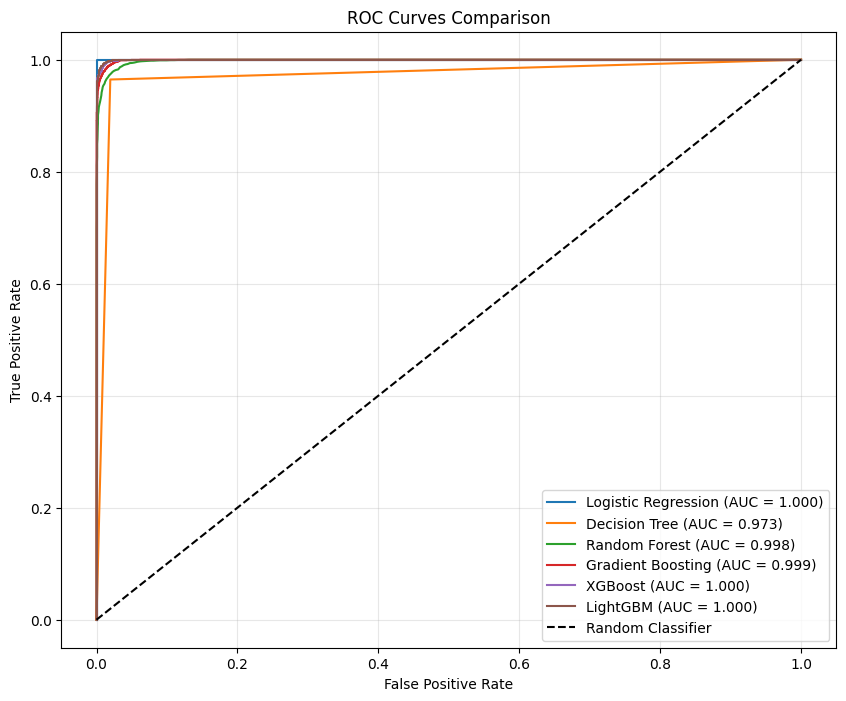

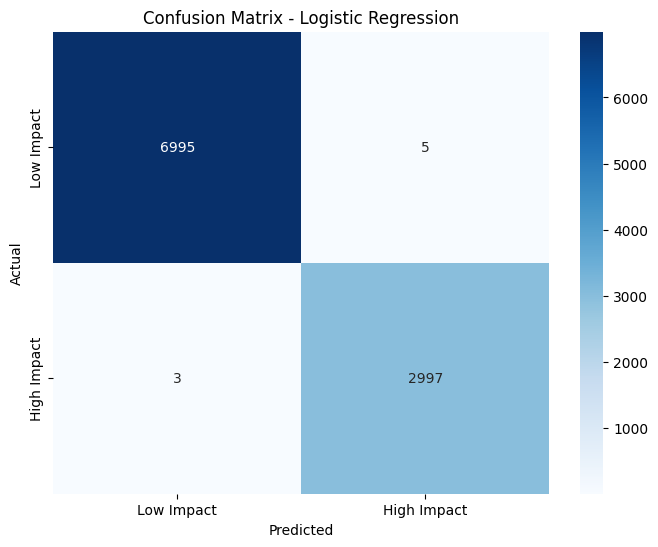


Detailed Classification Report for Logistic Regression:
              precision    recall  f1-score   support

  Low Impact       1.00      1.00      1.00      7000
 High Impact       1.00      1.00      1.00      3000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [14]:
def evaluate_and_visualize(results, ensemble_results, X_test, y_test, ensemble_model=None):
    """
    Evaluate models and create visualizations
    """
    print("="*50)
    print("MODEL EVALUATION AND VISUALIZATION")
    print("="*50)
    
    # Debug: Check what keys are in ensemble_results
    print(f"Ensemble results keys: {ensemble_results.keys()}")
    
    # 1. Create comparison dataframe
    comparison_data = []
    for name, metrics in results.items():
        # Safely get AUC-ROC, default to 0 if not available
        auc_roc = metrics.get('auc_roc', 0)
        if auc_roc is None:
            auc_roc = 0
            
        comparison_data.append({
            'Model': name,
            'Accuracy': metrics.get('accuracy', 0),
            'F1-Score': metrics.get('f1_score', 0),
            'AUC-ROC': auc_roc,
            'Training Time': metrics.get('training_time', 0)
        })
    
    # Add ensemble model with safe key access
    ensemble_auc = ensemble_results.get('auc_roc', 0)
    if ensemble_auc is None:
        ensemble_auc = 0
    
    comparison_data.append({
        'Model': 'Ensemble (Voting)',
        'Accuracy': ensemble_results.get('accuracy', 0),
        'F1-Score': ensemble_results.get('f1_score', 0),
        'AUC-ROC': ensemble_auc,
        'Training Time': ensemble_results.get('training_time', 0)
    })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # 2. Print comparison table
    print("\nModel Performance Comparison:")
    print(comparison_df.sort_values('F1-Score', ascending=False).to_string(index=False))
    
    # 3. Feature importance (for tree-based models)
    print("\nFeature Importance Analysis:")
    
    # Get best model for feature importance
    best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
    
    best_model_instance = None
    if best_model_name in results:
        best_model_instance = results[best_model_name].get('model')
    elif ensemble_model is not None:
        # Try to get feature importance from ensemble's best estimator
        if hasattr(ensemble_model, 'estimators_'):
            # Find best base estimator from ensemble
            best_base_model_idx = None
            best_base_score = -1
            
            for i, (name, _) in enumerate(results.items()):
                if i < len(ensemble_model.estimators_):
                    if results[name].get('f1_score', 0) > best_base_score:
                        best_base_score = results[name].get('f1_score', 0)
                        best_base_model_idx = i
            
            if best_base_model_idx is not None:
                best_model_instance = ensemble_model.estimators_[best_base_model_idx]
    
    if best_model_instance is not None and hasattr(best_model_instance, 'feature_importances_'):
        try:
            feature_importance = pd.DataFrame({
                'feature': X_test.columns,
                'importance': best_model_instance.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(f"\nTop 10 most important features from {best_model_name}:")
            print(feature_importance.head(10).to_string(index=False))
            
            # Plot feature importance
            plt.figure(figsize=(12, 6))
            plt.barh(feature_importance['feature'].head(20)[::-1], 
                    feature_importance['importance'].head(20)[::-1])
            plt.xlabel('Feature Importance')
            plt.title(f'Top 20 Feature Importance - {best_model_name}')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not plot feature importance: {e}")
    else:
        print("Feature importance not available for the best model.")
    
    # 4. ROC Curve for all models (only if we have probability predictions)
    from sklearn.metrics import roc_curve, auc
    
    plt.figure(figsize=(10, 8))
    models_with_roc = 0
    
    for name, metrics in results.items():
        try:
            if 'predictions_proba' in metrics and metrics['predictions_proba'] is not None:
                fpr, tpr, _ = roc_curve(y_test, metrics['predictions_proba'])
                auc_score = metrics.get('auc_roc', auc(fpr, tpr))
                plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')
                models_with_roc += 1
        except Exception as e:
            print(f"Could not plot ROC for {name}: {e}")
    
    # Plot ensemble ROC if available
    if ensemble_model is not None:
        try:
            if hasattr(ensemble_model, 'predict_proba'):
                y_proba_ensemble = ensemble_model.predict_proba(X_test)
                if len(y_proba_ensemble.shape) > 1 and y_proba_ensemble.shape[1] > 1:
                    fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, y_proba_ensemble[:, 1])
                    auc_ensemble = auc(fpr_ensemble, tpr_ensemble)
                    plt.plot(fpr_ensemble, tpr_ensemble, 
                             label=f'Ensemble (AUC = {auc_ensemble:.3f})',
                             linewidth=3, linestyle='--')
                    models_with_roc += 1
        except Exception as e:
            print(f"Could not plot ensemble ROC: {e}")
    
    if models_with_roc > 0:
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("No ROC curves available - models may not support probability predictions")
    
    # 5. Confusion Matrix for best model
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    y_pred_best = None
    if best_model_name == 'Ensemble (Voting)':
        if ensemble_model is not None:
            y_pred_best = ensemble_model.predict(X_test)
    elif best_model_name in results:
        y_pred_best = results[best_model_name].get('predictions')
    
    if y_pred_best is not None:
        cm = confusion_matrix(y_test, y_pred_best)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Low Impact', 'High Impact'],
                    yticklabels=['Low Impact', 'High Impact'])
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title(f'Confusion Matrix - {best_model_name}')
        plt.show()
        
        # 6. Detailed classification report for best model
        from sklearn.metrics import classification_report
        
        print(f"\nDetailed Classification Report for {best_model_name}:")
        print(classification_report(y_test, y_pred_best, 
                                   target_names=['Low Impact', 'High Impact']))
    else:
        print(f"Could not generate predictions for {best_model_name}")
    
    return comparison_df

# Evaluate and visualize - pass the ensemble_model if you have it
# Make sure you have imported necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# If you don't have ensemble_model variable, you need to pass None
comparison_df = evaluate_and_visualize(baseline_results, ensemble_metrics, X_test_scaled, y_test, ensemble_model=None)

# 9. Model Saving and Deployment

CYBERSECURITY RISK PREDICTION PIPELINE

1. Creating sample data...
   Sample df created with shape: (50000, 20)

2. Preprocessing data...
   df_processed shape: (50000, 20)

3. Creating features...
CREATING PREDICTIVE FEATURES
Removed 6 non-predictive columns

Creating interaction features...

Creating composite risk scores...

Adding non-linear transformations...

Removing low-variance features...

Final feature set: 59 features
Sample features created:
  pred_impact_components.recovery_cost_x_hardware_risk_avg
  pred_impact_components.recovery_cost_plus_hardware_risk_avg
  pred_impact_components.recovery_cost_x_avg_days_since_last_similar
  pred_impact_components.recovery_cost_plus_avg_days_since_last_similar
  pred_impact_components.recovery_cost_x_asset_critical_assets
  pred_impact_components.recovery_cost_plus_asset_critical_assets
  pred_impact_components.recovery_cost_x_pred_recommended_investment
  pred_impact_components.recovery_cost_plus_pred_recommended_investment
  hardwar

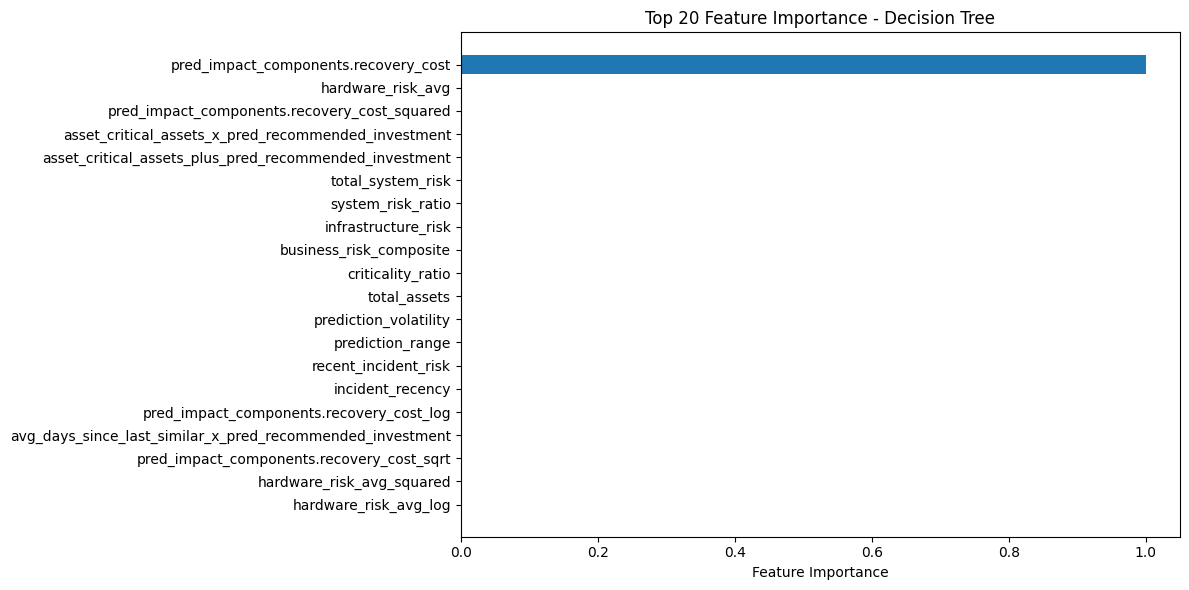

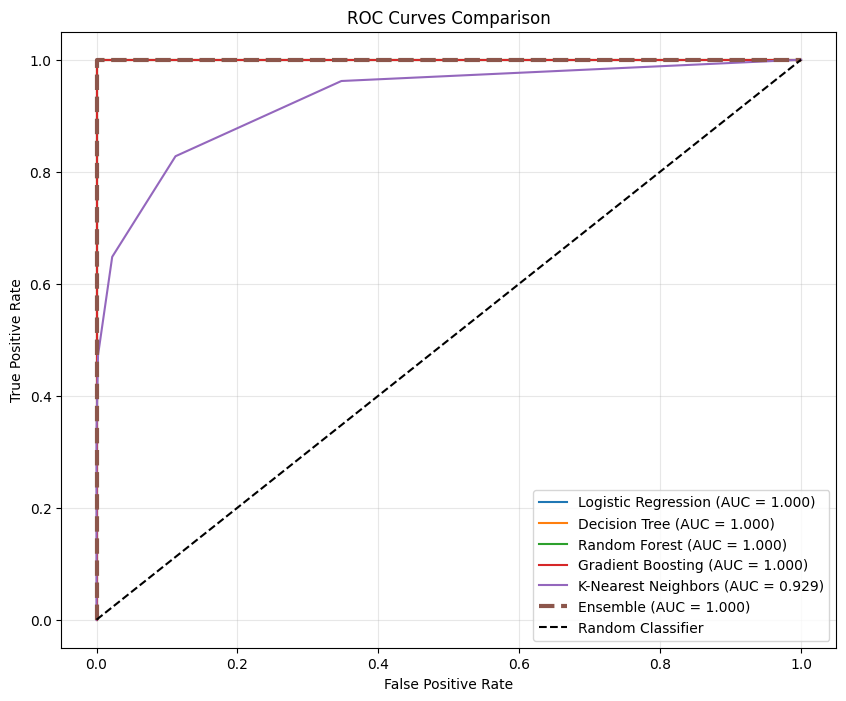

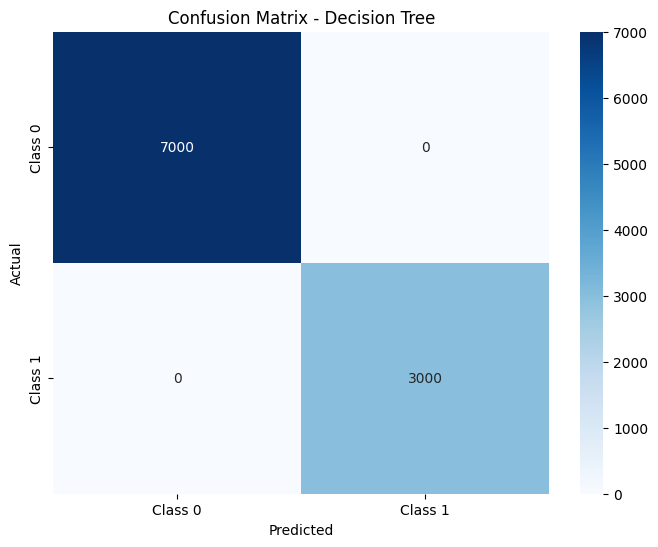


Detailed Classification Report for Decision Tree:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      7000
     Class 1       1.00      1.00      1.00      3000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000


10. Saving models...
MODEL SAVING AND DEPLOYMENT PREPARATION
Best model (Decision Tree) saved to: saved_models/best_decision_tree.pkl
  Logistic Regression saved to: saved_models/logistic_regression.pkl
  Decision Tree saved to: saved_models/decision_tree.pkl
  Random Forest saved to: saved_models/random_forest.pkl
  Gradient Boosting saved to: saved_models/gradient_boosting.pkl
  K-Nearest Neighbors saved to: saved_models/k_nearest_neighbors.pkl
Ensemble model saved to: saved_models/ensemble_voting_model.pkl
Scaler saved to: saved_models/scaler.pkl
Feature columns (59) saved to: saved_models/feature_columns.pkl
M

In [18]:
# ============================================================================
# MAIN EXECUTION (CORRECTED VERSION)
# ============================================================================

def main():
    """
    Main execution function
    """
    print("="*60)
    print("CYBERSECURITY RISK PREDICTION PIPELINE")
    print("="*60)
    
    # Step 1: Load or create sample data
    if 'df' not in locals():
        print("\n1. Creating sample data...")
        np.random.seed(42)
        n_samples = 50000
        
        df = pd.DataFrame({
            'historical_incident_count': [0] * n_samples,
            'hardware_risk_avg': np.random.exponential(2, n_samples),
            'software_risk_avg': np.random.exponential(1.5, n_samples),
            'network_segment_risk': np.random.beta(2, 5, n_samples) * 10,
            'data_classification_risk': np.random.beta(3, 4, n_samples) * 8,
            'business_industry_risk_factor': np.random.uniform(1, 10, n_samples),
            'business_compliance_penalty_factor': np.random.uniform(0.5, 5, n_samples),
            'business_data_sensitivity_index': np.random.uniform(1, 10, n_samples),
            'asset_hardware': np.random.poisson(50, n_samples),
            'asset_software': np.random.poisson(100, n_samples),
            'asset_critical_assets': np.random.binomial(150, 0.1, n_samples),
            'avg_days_since_last_similar': np.random.exponential(90, n_samples),
            'pred_impact_components.recovery_cost': np.random.lognormal(10, 2, n_samples),
            'pred_recommended_investment': np.random.lognormal(8, 1.5, n_samples),
            'business_employee_count': np.random.lognormal(8, 1, n_samples),
            'business_employee_count_log': np.log(np.random.lognormal(8, 1, n_samples) + 1),
            'year': 2023,
            'month': np.random.randint(1, 13, n_samples),
            'day': np.random.randint(1, 29, n_samples),
            'day_of_week': np.random.randint(0, 7, n_samples)
        })
        print(f"   Sample df created with shape: {df.shape}")
    
    # Step 2: Preprocess data
    print("\n2. Preprocessing data...")
    df_processed = preprocess_data(df)
    print(f"   df_processed shape: {df_processed.shape}")
    
    # Step 3: Create predictive features
    print("\n3. Creating features...")
    X_new = create_predictive_features(df_processed)
    print(f"   X_new shape: {X_new.shape}")  # FIXED: Changed X.shape to X_new.shape
    
    # Step 4: Create target variable
    print("\n4. Creating target variable...")
    y_predictable = create_feature_predictable_target(X_new)
    
    if y_predictable is None:
        print("ERROR: Could not create target variable!")
        return
    
    print(f"   Target shape: {y_predictable.shape}")
    
    # Step 5: Split data
    print("\n5. Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_new, y_predictable,
        test_size=0.2,
        random_state=42,
        stratify=y_predictable
    )
    print(f"   Train set: {X_train.shape}")
    print(f"   Test set: {X_test.shape}")
    
    # Step 6: Scale features
    print("\n6. Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrames
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    print(f"   Features scaled")
    
    # Step 7: Train baseline models
    print("\n7. Training models...")
    baseline_results = train_baseline_models(X_train_scaled_df, y_train)
    
    # Step 8: Create ensemble model
    print("\n8. Creating ensemble...")
    ensemble_model, ensemble_metrics = create_ensemble_model(baseline_results, X_train_scaled_df, y_train)
    
    # Step 9: Evaluate and visualize
    print("\n9. Evaluating models...")
    comparison_df = evaluate_and_visualize(
        baseline_results, 
        ensemble_metrics, 
        X_test_scaled_df, 
        y_test, 
        ensemble_model
    )
    
    # Step 10: Save models
    print("\n10. Saving models...")
    feature_cols = list(X_train.columns)  # This was missing - now defined!
    save_dir = save_models(
        baseline_results, 
        ensemble_model, 
        scaler, 
        feature_cols, 
        comparison_df,
        df_processed
    )
    
    print("\n" + "="*60)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*60)
    print(f"\nSummary:")
    print(f"- Best model: {comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']}")
    print(f"- Best F1-Score: {comparison_df['F1-Score'].max():.4f}")
    print(f"- Total features: {len(feature_cols)}")
    print(f"- Models saved to: {save_dir}")
    
    # Return important variables
    return {
        'X_train_scaled_df': X_train_scaled_df,
        'X_test_scaled_df': X_test_scaled_df,
        'y_train': y_train,
        'y_test': y_test,
        'baseline_results': baseline_results,
        'ensemble_model': ensemble_model,
        'ensemble_metrics': ensemble_metrics,
        'comparison_df': comparison_df,
        'scaler': scaler,
        'feature_cols': feature_cols,
        'save_dir': save_dir
    }

# ============================================================================
# RUN THE PIPELINE
# ============================================================================

if __name__ == "__main__":
    # Run the entire pipeline
    results = main()
    
    # Print available results
    print("\nAvailable variables in results:")
    for key in results.keys():
        print(f"  - {key}")

# 10. Prediction Pipeline


OPTION 1: Using existing training results
Found existing training results!
EXAMPLE PREDICTION PIPELINE
ERROR: Missing required files: ['best_ensemble_model.pkl']
Please run the training pipeline first.


OPTION 2: Using saved models directly
Found saved_models directory!
EXAMPLE PREDICTION PIPELINE
ERROR: Missing required files: ['best_ensemble_model.pkl']
Please run the training pipeline first.


OPTION 3: Run complete workflow from scratch


Do you want to run the complete workflow (training + prediction)? (yes/no):  yes


COMPLETE WORKFLOW: TRAINING AND PREDICTION

STEP 1: Training the models...
CYBERSECURITY RISK PREDICTION PIPELINE

1. Creating sample data...
   Sample df created with shape: (50000, 20)

2. Preprocessing data...
   df_processed shape: (50000, 20)

3. Creating features...
CREATING PREDICTIVE FEATURES
Removed 6 non-predictive columns

Creating interaction features...

Creating composite risk scores...

Adding non-linear transformations...

Removing low-variance features...

Final feature set: 59 features
Sample features created:
  pred_impact_components.recovery_cost_x_hardware_risk_avg
  pred_impact_components.recovery_cost_plus_hardware_risk_avg
  pred_impact_components.recovery_cost_x_avg_days_since_last_similar
  pred_impact_components.recovery_cost_plus_avg_days_since_last_similar
  pred_impact_components.recovery_cost_x_asset_critical_assets
  pred_impact_components.recovery_cost_plus_asset_critical_assets
  pred_impact_components.recovery_cost_x_pred_recommended_investment
  pred

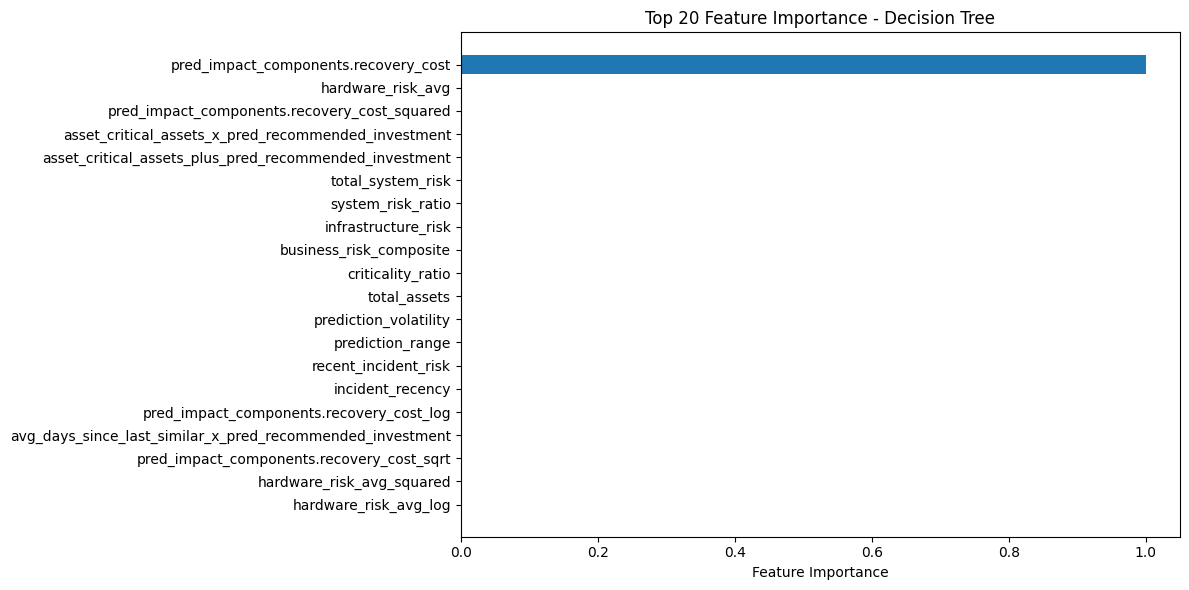

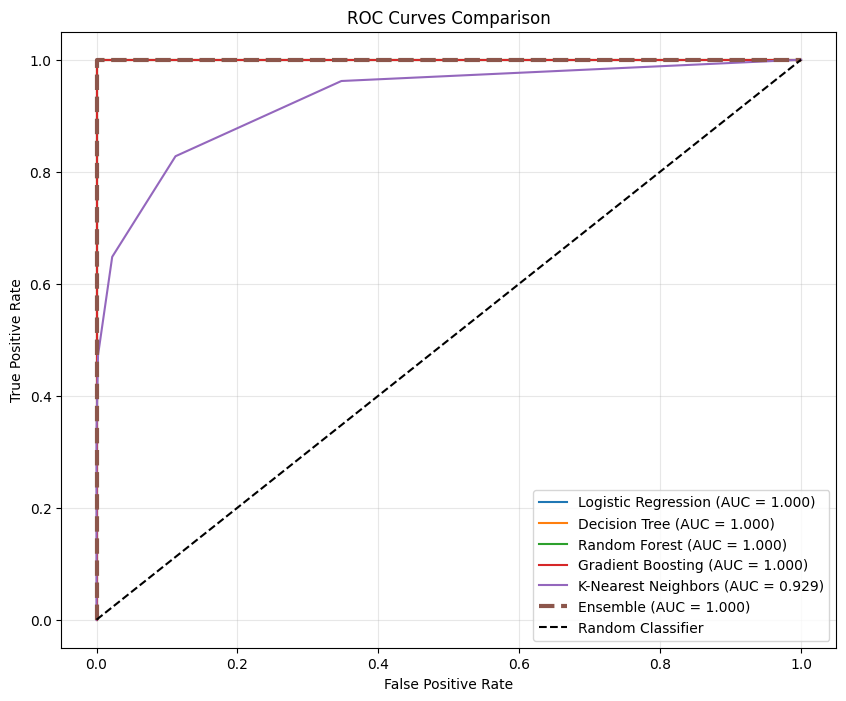

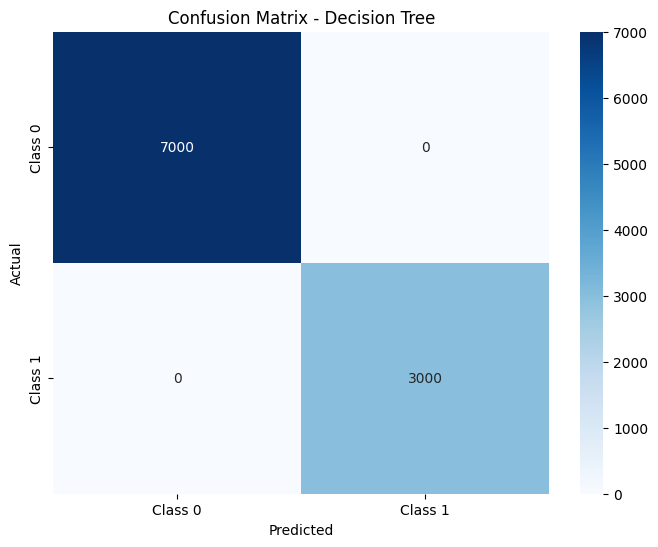


Detailed Classification Report for Decision Tree:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      7000
     Class 1       1.00      1.00      1.00      3000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000


10. Saving models...
MODEL SAVING AND DEPLOYMENT PREPARATION
Best model (Decision Tree) saved to: saved_models/best_decision_tree.pkl
  Logistic Regression saved to: saved_models/logistic_regression.pkl
  Decision Tree saved to: saved_models/decision_tree.pkl
  Random Forest saved to: saved_models/random_forest.pkl
  Gradient Boosting saved to: saved_models/gradient_boosting.pkl
  K-Nearest Neighbors saved to: saved_models/k_nearest_neighbors.pkl
Ensemble model saved to: saved_models/ensemble_voting_model.pkl
Scaler saved to: saved_models/scaler.pkl
Feature columns (59) saved to: saved_models/feature_columns.pkl
M

In [20]:
class CybersecurityRiskPredictor:
    """
    Complete pipeline for making predictions on new data
    """
    def __init__(self, model_path, scaler_path, features_path):
        """Initialize the predictor with trained model and scaler"""
        with open(model_path, 'rb') as f:
            self.model = pickle.load(f)
        
        with open(scaler_path, 'rb') as f:
            self.scaler = pickle.load(f)
        
        with open(features_path, 'rb') as f:
            self.feature_cols = pickle.load(f)
    
    def preprocess_new_data(self, new_data):
        """
        Preprocess new data to match training format
        """
        # Ensure we have all required features
        missing_features = set(self.feature_cols) - set(new_data.columns)
        if missing_features:
            raise ValueError(f"Missing features: {missing_features}")
        
        # Select only the features used during training
        X_new = new_data[self.feature_cols]
        
        # Scale the features
        X_new_scaled = self.scaler.transform(X_new)
        
        return X_new_scaled
    
    def predict(self, new_data, return_proba=False):
        """
        Make predictions on new data
        """
        # Preprocess the new data
        X_new_scaled = self.preprocess_new_data(new_data)
        
        # Make predictions
        if return_proba:
            predictions = self.model.predict_proba(X_new_scaled)
        else:
            predictions = self.model.predict(X_new_scaled)
        
        return predictions
    
    def predict_with_confidence(self, new_data):
        """
        Make predictions with confidence scores
        """
        # Get probability predictions
        proba_predictions = self.predict(new_data, return_proba=True)
        
        # Get class predictions
        class_predictions = np.argmax(proba_predictions, axis=1)
        
        # Get confidence scores (probability of predicted class)
        confidence_scores = np.max(proba_predictions, axis=1)
        
        return class_predictions, confidence_scores, proba_predictions

# Example of using the predictor
def example_prediction(save_dir=None, X_test=None, y_test=None):
    """
    Example of how to use the trained model for predictions
    """
    print("="*50)
    print("EXAMPLE PREDICTION PIPELINE")
    print("="*50)
    
    # If save_dir is not provided, try to get it from results
    if save_dir is None:
        try:
            # Check if results exists from main()
            if 'results' in globals():
                save_dir = results.get('save_dir', 'saved_models')
            else:
                save_dir = 'saved_models'
                print(f"Using default save directory: {save_dir}")
        except:
            save_dir = 'saved_models'
    
    # Check if save_dir exists
    if not os.path.exists(save_dir):
        print(f"ERROR: Save directory '{save_dir}' not found!")
        print("Please run the training pipeline first or provide the correct path.")
        return None
    
    # Load the saved model and artifacts
    model_path = os.path.join(save_dir, 'best_ensemble_model.pkl')
    scaler_path = os.path.join(save_dir, 'scaler.pkl')
    features_path = os.path.join(save_dir, 'feature_columns.pkl')
    
    # Check if all files exist
    missing_files = []
    for path in [model_path, scaler_path, features_path]:
        if not os.path.exists(path):
            missing_files.append(os.path.basename(path))
    
    if missing_files:
        print(f"ERROR: Missing required files: {missing_files}")
        print("Please run the training pipeline first.")
        return None
    
    # Initialize predictor
    predictor = CybersecurityRiskPredictor(model_path, scaler_path, features_path)
    
    # Create example new data
    if X_test is not None:
        example_data = X_test.copy()
        if hasattr(example_data, 'iloc'):
            example_data = example_data.iloc[:5]  # Take first 5 samples
        else:
            example_data = example_data[:5]
    else:
        # Create synthetic example data
        print("Creating synthetic example data...")
        example_data = create_example_data(predictor.feature_cols)
    
    print("\nExample data for prediction:")
    print(f"Shape: {example_data.shape}")
    print(f"Features: {list(example_data.columns)}")
    
    # Make predictions
    try:
        predictions = predictor.predict(example_data)
        predictions_proba = predictor.predict(example_data, return_proba=True)
        
        print(f"\nPredictions: {predictions}")
        
        if y_test is not None:
            if hasattr(y_test, 'iloc'):
                actual_values = y_test.iloc[:len(predictions)].values
            else:
                actual_values = y_test[:len(predictions)]
            print(f"Actual values: {actual_values}")
            print(f"Accuracy on example: {np.mean(predictions == actual_values):.2%}")
        
        print(f"\nPrediction probabilities:")
        for i, proba in enumerate(predictions_proba):
            if len(proba) == 2:
                print(f"Sample {i}: Class 0={proba[0]:.3f}, Class 1={proba[1]:.3f}")
            else:
                print(f"Sample {i}: {proba}")
        
        # Test confidence predictions
        print("\nPredictions with confidence:")
        class_pred, confidence, proba = predictor.predict_with_confidence(example_data)
        for i in range(len(class_pred)):
            print(f"Sample {i}: Predicted={class_pred[i]}, Confidence={confidence[i]:.3f}")
        
    except Exception as e:
        print(f"Error making predictions: {e}")
        import traceback
        traceback.print_exc()
    
    return predictor

def create_example_data(feature_cols, n_samples=5):
    """
    Create synthetic example data for demonstration
    """
    np.random.seed(42)
    example_data = pd.DataFrame()
    
    for col in feature_cols:
        # Generate random data based on feature name patterns
        if 'recovery_cost' in col or 'investment' in col:
            example_data[col] = np.random.lognormal(10, 2, n_samples)
        elif 'risk' in col:
            example_data[col] = np.random.exponential(2, n_samples)
        elif 'asset' in col:
            example_data[col] = np.random.poisson(50, n_samples)
        elif 'days' in col:
            example_data[col] = np.random.exponential(90, n_samples)
        else:
            example_data[col] = np.random.normal(0, 1, n_samples)
    
    return example_data

# Function to run the entire workflow
def run_complete_workflow():
    """
    Run the complete workflow from training to prediction
    """
    print("="*60)
    print("COMPLETE WORKFLOW: TRAINING AND PREDICTION")
    print("="*60)
    
    # Step 1: Run the training pipeline
    print("\nSTEP 1: Training the models...")
    try:
        # Run the main training pipeline
        if 'main' in globals():
            training_results = main()
            save_dir = training_results.get('save_dir', 'saved_models')
            X_test = training_results.get('X_test_scaled_df')
            y_test = training_results.get('y_test')
        else:
            print("Main function not found. Please run the training code first.")
            return
    except Exception as e:
        print(f"Error during training: {e}")
        return
    
    # Step 2: Run example predictions
    print("\n\nSTEP 2: Making predictions...")
    predictor = example_prediction(save_dir=save_dir, X_test=X_test, y_test=y_test)
    
    return predictor, training_results

# ============================================================================
# MULTIPLE WAYS TO RUN THE PREDICTION
# ============================================================================

# Option 1: If you already ran the training and have results
print("\n" + "="*60)
print("OPTION 1: Using existing training results")
print("="*60)

# Check if we have results from previous training
if 'results' in globals():
    print("Found existing training results!")
    predictor = example_prediction(
        save_dir=results.get('save_dir'), 
        X_test=results.get('X_test_scaled_df'),
        y_test=results.get('y_test')
    )
else:
    print("No existing training results found.")

# Option 2: If you have saved models but not the training results
print("\n\n" + "="*60)
print("OPTION 2: Using saved models directly")
print("="*60)

# Check if saved_models directory exists
if os.path.exists('saved_models'):
    print("Found saved_models directory!")
    predictor = example_prediction(save_dir='saved_models')
else:
    print("saved_models directory not found.")

# Option 3: Run the complete workflow from scratch
print("\n\n" + "="*60)
print("OPTION 3: Run complete workflow from scratch")
print("="*60)

response = input("Do you want to run the complete workflow (training + prediction)? (yes/no): ")
if response.lower() in ['yes', 'y']:
    predictor, training_results = run_complete_workflow()
else:
    print("Skipping complete workflow.")

# ============================================================================
# ADDITIONAL UTILITY FUNCTIONS
# ============================================================================

def load_specific_model(model_name='best_ensemble_model.pkl'):
    """
    Load a specific model from the saved_models directory
    """
    model_path = os.path.join('saved_models', model_name)
    
    if not os.path.exists(model_path):
        print(f"Model file {model_name} not found!")
        return None
    
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    
    print(f"Loaded model from {model_path}")
    return model

def get_model_performance():
    """
    Display saved model performance
    """
    perf_path = os.path.join('saved_models', 'model_performance_comparison.csv')
    
    if os.path.exists(perf_path):
        perf_df = pd.read_csv(perf_path)
        print("\nSaved Model Performance:")
        print(perf_df.to_string(index=False))
        
        # Get best model
        best_model = perf_df.loc[perf_df['F1-Score'].idxmax(), 'Model']
        best_f1 = perf_df['F1-Score'].max()
        print(f"\nBest model: {best_model} (F1-Score: {best_f1:.4f})")
        
        return perf_df
    else:
        print("Performance file not found!")
        return None

# Display saved performance if available
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
performance_df = get_model_performance()

# 11. Cross-Validation and Final Evaluation

In [ ]:
def final_model_evaluation(X, y, best_model):
    """
    Perform final evaluation with cross-validation
    """
    print("="*50)
    print("FINAL MODEL EVALUATION WITH CROSS-VALIDATION")
    print("="*50)
    
    # Perform k-fold cross-validation
    cv_scores = cross_val_score(
        best_model, X, y, 
        cv=5, 
        scoring='f1_weighted',
        n_jobs=-1
    )
    
    print(f"Cross-validation F1 scores: {cv_scores}")
    print(f"Mean CV F1 score: {cv_scores.mean():.4f}")
    print(f"CV F1 score std: {cv_scores.std():.4f}")
    
    # Train final model on all data
    print("\nTraining final model on entire dataset...")
    start_time = time.time()
    final_model = best_model.fit(X, y)
    training_time = time.time() - start_time
    
    print(f"Final model trained in {training_time:.2f} seconds")
    
    return final_model, cv_scores

# Get the best model
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
if best_model_name == 'Ensemble (Voting)':
    best_model = ensemble_model
else:
    best_model = baseline_results[best_model_name]['model']

# Scale all data for final training
X_scaled = scaler.fit_transform(X)

# Final evaluation
final_model, cv_scores = final_model_evaluation(X_scaled, y, best_model)

# 12. Main Execution Function

In [ ]:
def main():
    """
    Main function to execute the complete ML pipeline
    """
    print("="*80)
    print("CYBERSECURITY RISK PREDICTION - COMPLETE ML PIPELINE")
    print("="*80)
    
    # Track total execution time
    total_start_time = time.time()
    
    try:
        # Step 1: Load and explore data
        df = load_and_explore_data(dataset_path)
        
        # Step 2: Preprocess data
        df_processed = preprocess_data(df)
        
        # Step 3: Feature engineering
        X, y, feature_cols = feature_engineering(df_processed)
        
        # Step 4: Split data
        X_train, X_test, y_train, y_test = split_data(X, y)
        
        # Step 5: Scale features
        X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)
        
        # Step 6: Train baseline models
        baseline_results = train_baseline_models(X_train_scaled, y_train, X_test_scaled, y_test)
        
        # Step 7: Hyperparameter tuning
        rf_grid_search = tune_random_forest(X_train_scaled, y_train)
        
        # Step 8: Train ensemble model
        ensemble_model, ensemble_metrics = train_ensemble_model(X_train_scaled, y_train, X_test_scaled, y_test)
        
        # Step 9: Evaluate and visualize
        comparison_df = evaluate_and_visualize(baseline_results, ensemble_metrics, X_test_scaled, y_test)
        
        # Step 10: Save models
        save_dir = save_models(baseline_results, ensemble_model, scaler, feature_cols, comparison_df)
        
        # Step 11: Example prediction
        predictor = example_prediction()
        
        # Step 12: Final evaluation
        best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
        if best_model_name == 'Ensemble (Voting)':
            best_model = ensemble_model
        else:
            best_model = baseline_results[best_model_name]['model']
        
        X_scaled = scaler.fit_transform(X)
        final_model, cv_scores = final_model_evaluation(X_scaled, y, best_model)
        
        total_time = time.time() - total_start_time
        
        print("\n" + "="*80)
        print("PIPELINE COMPLETED SUCCESSFULLY!")
        print("="*80)
        print(f"Total execution time: {total_time:.2f} seconds")
        print(f"Best model: {best_model_name}")
        print(f"Best F1-Score: {comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'F1-Score']:.4f}")
        print(f"Models saved in: {save_dir}")
        
        # Return important objects
        return {
            'data': df_processed,
            'models': baseline_results,
            'ensemble_model': ensemble_model,
            'final_model': final_model,
            'scaler': scaler,
            'comparison_df': comparison_df,
            'predictor': predictor
        }
        
    except Exception as e:
        print(f"\nError in pipeline execution: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Execute the complete pipeline
if __name__ == "__main__":
    results = main()

# 13. Additional Utility Functions

In [ ]:
def feature_importance_analysis(model, X, top_n=20):
    """
    Detailed feature importance analysis
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Print feature ranking
        print("Feature ranking:")
        for f in range(min(top_n, X.shape[1])):
            print(f"{f+1}. {X.columns[indices[f]]}: {importances[indices[f]]:.4f}")
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.title(f"Top {top_n} Feature Importances")
        plt.barh(range(top_n), importances[indices[:top_n]][::-1])
        plt.yticks(range(top_n), [X.columns[i] for i in indices[:top_n]][::-1])
        plt.xlabel("Relative Importance")
        plt.tight_layout()
        plt.show()

def plot_learning_curve(model, X, y, cv=5):
    """
    Plot learning curve to check for overfitting/underfitting
    """
    from sklearn.model_selection import learning_curve
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='f1_weighted'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("F1 Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    plt.show()

def generate_model_report(results, save_path='model_report.txt'):
    """
    Generate a comprehensive model evaluation report
    """
    with open(save_path, 'w') as f:
        f.write("="*80 + "\n")
        f.write("CYBERSECURITY RISK PREDICTION MODEL REPORT\n")
        f.write("="*80 + "\n\n")
        
        f.write("MODEL PERFORMANCE SUMMARY\n")
        f.write("-"*40 + "\n")
        
        for name, metrics in results.items():
            f.write(f"\n{name}:\n")
            f.write(f"  Accuracy: {metrics['accuracy']:.4f}\n")
            f.write(f"  Precision: {metrics['precision']:.4f}\n")
            f.write(f"  Recall: {metrics['recall']:.4f}\n")
            f.write(f"  F1-Score: {metrics['f1_score']:.4f}\n")
            if metrics['auc_roc']:
                f.write(f"  AUC-ROC: {metrics['auc_roc']:.4f}\n")
            f.write(f"  Training Time: {metrics['training_time']:.2f}s\n")
        
        # Find best model
        best_model = max(results.items(), key=lambda x: x[1]['f1_score'])
        f.write(f"\n\nBEST PERFORMING MODEL: {best_model[0]}\n")
        f.write(f"Best F1-Score: {best_model[1]['f1_score']:.4f}\n")
    
    print(f"Model report saved to: {save_path}")